In [141]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import time
import imutils
import csv
from scipy.spatial import distance
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import cross_val_score

svmClassifier = joblib.load('finalized_model.sav')

In [142]:
# read ground truth localization values

ground_truth_id = []
ground_truth_class = []
ground_truth_coordinates = []

with open('MIO-TCD-Localization/gt_train.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        ground_truth_id.append(row[0])
        ground_truth_class.append(row[1])
        coordinates = list(map(int,[row[2],row[3],row[4],row[5]]))
        ground_truth_coordinates.append(coordinates)
        
        if line_count == 0:
            line_count += 1
        else:
            line_count += 1
    print("rows read ", line_count)
            
ground_truth_id = np.array(ground_truth_id)
ground_truth_class = np.array(ground_truth_class)
ground_truth_coordinates = np.array(ground_truth_coordinates)

rows read  351549


In [143]:
def getHogFeatures(images):
    cell_size = (4, 4)  # h x w in pixels
    block_size = (4, 4)  # h x w in cells
    nbins = 8  # number of orientation bins
    
    hog = cv2.HOGDescriptor(_winSize=(images[0].shape[1] // cell_size[1] * cell_size[1],
                                          images[0].shape[0] // cell_size[0] * cell_size[0]),
                                _blockSize=(block_size[1] * cell_size[1],
                                            block_size[0] * cell_size[0]),
                                _blockStride=(cell_size[1], cell_size[0]),
                                _cellSize=(cell_size[1], cell_size[0]),
                                _nbins=nbins)
    
    n_cells = (images[0].shape[0] // cell_size[0], images[0].shape[1] // cell_size[1])
    
    listOfHogFeatures = []
    for img in images:
        # create HoG Object
        # winSize is the size of the image cropped to an multiple of the cell size
        

        # Compute HoG features
        hog_feats = hog.compute(img)\
                       .reshape(n_cells[1] - block_size[1] + 1,
                                n_cells[0] - block_size[0] + 1,
                                block_size[0], block_size[1], nbins) \
                       .transpose((1, 0, 2, 3, 4))  # index blocks by rows first

        # hog_feats now contains the gradient amplitudes for each direction,for each cell of its group for each group.
        # Indexing is by rows then columns.
        # computation for BlockNorm
        gradients = np.full((n_cells[0], n_cells[1], 8), 0, dtype=float)
        cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

        for off_y in range(block_size[0]):
            for off_x in range(block_size[1]):
                gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                          off_x:n_cells[1] - block_size[1] + off_x + 1] += \
                    hog_feats[:, :, off_y, off_x, :]
                cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                           off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

        # Average gradients
        gradients /= cell_count
        # turn gradient 32,32,8 3D array to 1D for training 
        reshaped_gradients = gradients.ravel()
        listOfHogFeatures.append(reshaped_gradients)
        
    return listOfHogFeatures

In [144]:
def calculate_dice_coefficient(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
 
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return dice coefficient based on intersection of union
    dice_coefficient = (2 * iou)/(iou + 1)
    return dice_coefficient

In [145]:
# extract images from localization
def extract_localization_images(path, extracted_images, extracted_value, image_ids):
    extracted_count = 0
    test_count = 0
    
    ## resize images to 128x128 grayscale 
    for file in os.listdir(path):
    # grab only 1 images from train directory for testing purposes 
        if (extracted_count < extracted_value):
            img = cv2.cvtColor(cv2.imread(os.path.join(path + "/" + file)), cv2.COLOR_BGR2GRAY)
            extracted_images.append(img)
            extracted_count = extracted_count + 1 
            image_ids.append(""+file[:-4])
            
        else:
            break
                            
    return extracted_images


In [146]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [147]:
def pyramid(image, scale=1.5, minSize=(30, 30)):
    # yield the original image
    yield image
 
    # keep looping over the pyramid
    while True:
        # compute the new dimensions of the image and resize it
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)
 
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
 
        # yield the next image in the pyramid
        yield image

In [148]:
def draw_gt_values(img, class_coordinates):
    
    for coordinates in class_coordinates:
        print(coordinates)
        xy = (int(coordinates[0]), int(coordinates[1]))
        w = int(coordinates[2])
        h = int(coordinates[3])
        cv2.rectangle(img, xy, (w,h), (0,255,0), 2)
    

In [149]:
def get_ground_truth_values(image_id):
    classes = ground_truth_class[ground_truth_id == image_id]
    class_coordinates = ground_truth_coordinates[ground_truth_id == image_id]
    return classes, class_coordinates

In [150]:
def multi_scale_sliding_window(localization_image, window_width, window_height, step_size):
    patches = []
    patches_coordinates = []
    patches_classes = []

    # loop over the image pyramid
    for resized in pyramid(localization_image, scale=1.5):
        # loop over the sliding window for each layer of the pyramid
        for (x, y, window) in sliding_window(resized, stepSize=step_size, windowSize=(window_width, window_height)):
            # if the window does not meet our desired window size, ignore it
            if window.shape[0] != window_width or window.shape[1] != window_height:
                continue

            window_hog_features = getHogFeatures([window])
            prediction = svmClassifier.predict(window_hog_features)

            if (prediction != 0):
                patches.append(window)
                patches_coordinates.append([x,y,x+window_width,y+window_height])
                patches_classes.append(prediction)

    print("MULTISCALE SLIDING WINDOW DONE")
    return patches, patches_coordinates, patches_classes

In [155]:
# ignore all the false positives and attempt to pick closest distance.

def calculate_localization_results(localization_image, gt_classes, gt_class_coordinates, patches, patches_coordinates, patches_classes):
    dice_coefficient_values = []
    prediction_results = []

    for gt_class, gt_coordinates in zip(gt_classes, gt_class_coordinates):
        closest_coordinates = []
        for patch, p_coordinates in zip(patches, patches_coordinates):
            distance_from_gt = distance.euclidean(p_coordinates, gt_coordinates)
            closest_coordinates.append(distance_from_gt)

        
        closest_coordinates = np.array(closest_coordinates)
        min_index = np.argmin(closest_coordinates)
        min_coordinates = patches_coordinates[min_index]

        dice_coefficient = calculate_dice_coefficient(min_coordinates, gt_coordinates)
        dice_coefficient_values.append(dice_coefficient)

        prediction_results.append(patches_classes[min_index])

        cv2.rectangle(localization_image,(min_coordinates[0],min_coordinates[1]), (min_coordinates[2],min_coordinates[3]), (0,0,255), 2) 

    mean_dice_coefficient = np.mean(dice_coefficient_values)
    print("MEAN_DICE_COEFFICIENT : ", mean_dice_coefficient)
    return mean_dice_coefficient, prediction_results

#### SVM + HOG LOCALIZATION


In [156]:
# model doesn't give class as string but as a number 
# silly conversion way to test out cross validation

def convert_int_to_class(prediction):
    if (prediction == 0):
        return "background"
    elif (prediction == 1):
        return "articulated_truck"
    elif (prediction == 2):
        return "bicycle"
    elif (prediction == 3):
        return "bus"
    elif (prediction == 4):
        return "car"
    elif (prediction == 5):
        return "motorcycle"
    elif (prediction == 6):
        return "non-motorized_vehicle"
    elif (prediction == 7):
        return "pedestrian"
    elif (prediction == 8):
        return "pickup_truck"
    elif (prediction == 9):
        return "single_unit_truck"
    elif (prediction == 10):
        return "work_van"

    

        

In [157]:
training_set_path= r"./MIO-TCD-Localization/train"
train_images = []
train_value = 100
image_ids = []

extract_localization_images(training_set_path, train_images, train_value,image_ids)
print(len(train_images))
print(len(image_ids))

100
100


In [158]:
# localize all vehicles in each image

dice_coefficient_images = []
all_class_predictions = []
all_ground_truth_classes = []

window_width = 80
window_height = 80
step_size = 32 
    
for localization_image, image_id in zip(train_images,image_ids):

    patches, patches_coordinates, patches_classes = multi_scale_sliding_window(localization_image, window_width, window_height, step_size)
    
    img = cv2.imread(r"./MIO-TCD-Localization/train/"+ str(image_id) + ".jpg")
    gt_classes, gt_class_coordinates = get_ground_truth_values(image_id)
    
    patches_classes = np.array(patches_classes)
    draw_gt_values(img, gt_class_coordinates)

    for box_coordinates in patches_coordinates:
        x,y = box_coordinates[0],box_coordinates[1]
        cv2.rectangle(img,(box_coordinates[0],box_coordinates[1]), (box_coordinates[2],box_coordinates[3]), (0,0,255), 2) 
    
    localization_image_dice, class_predictions = calculate_localization_results(localization_image, gt_classes, gt_class_coordinates, patches, patches_coordinates, patches_classes)
    dice_coefficient_images.append(localization_image_dice)
    
    for prediction in class_predictions:
        all_class_predictions.append(convert_int_to_class(prediction))
    for gt_class in gt_classes:
        all_ground_truth_classes.append(gt_class)
#     all_class_predictions.append(class_predictions)
#     all_ground_truth_classes.append(gt_classes)
    
    cv2.imwrite("./svm_localization/" + str(image_id)+"_svm" + ".jpg",img)
    

MULTISCALE SLIDING WINDOW DONE
[213  34 255  50]
[194  78 273 122]
[155  27 183  35]
[ 43  25 109  55]
[106  32 124  45]
MEAN_DICE_COEFFICIENT :  0.3071138717722354
MULTISCALE SLIDING WINDOW DONE
[205 155 568 314]
[285 123 477 168]
[544 162 617 193]
[329 152 371 163]
[447 161 497 183]
[662 199 715 236]
MEAN_DICE_COEFFICIENT :  0.34079490188445805
MULTISCALE SLIDING WINDOW DONE
[334 362 603 479]
MEAN_DICE_COEFFICIENT :  0.29936753338018274
MULTISCALE SLIDING WINDOW DONE
[480  99 511 120]
[257 199 369 280]
MEAN_DICE_COEFFICIENT :  0.47094731397829537
MULTISCALE SLIDING WINDOW DONE
[439  32 719 171]
MEAN_DICE_COEFFICIENT :  0.2682294503387726
MULTISCALE SLIDING WINDOW DONE
[561  85 605 129]
[132   3 712 254]
MEAN_DICE_COEFFICIENT :  0.27873897835467076
MULTISCALE SLIDING WINDOW DONE
[ 22 135 136 204]
MEAN_DICE_COEFFICIENT :  0.7761275751146396
MULTISCALE SLIDING WINDOW DONE
[471 175 708 386]
MEAN_DICE_COEFFICIENT :  0.2301418875072347
MULTISCALE SLIDING WINDOW DONE
[471 131 702 249]
MEAN_

MULTISCALE SLIDING WINDOW DONE
[379 120 460 178]
[  9 270 156 381]
MEAN_DICE_COEFFICIENT :  0.668605543056082
MULTISCALE SLIDING WINDOW DONE
[293 199 437 278]
MEAN_DICE_COEFFICIENT :  0.6600958097021089
MULTISCALE SLIDING WINDOW DONE
[229 123 273 164]
[431 107 456 126]
MEAN_DICE_COEFFICIENT :  0.2970781278974965
MULTISCALE SLIDING WINDOW DONE
[306 197 444 265]
MEAN_DICE_COEFFICIENT :  0.6920505200594353
MULTISCALE SLIDING WINDOW DONE
[350 195 448 253]
[462 119 498 141]
MEAN_DICE_COEFFICIENT :  0.50015488945475
MULTISCALE SLIDING WINDOW DONE
[654  93 667 109]
[227 122 379 189]
MEAN_DICE_COEFFICIENT :  0.33102636797500645
MULTISCALE SLIDING WINDOW DONE
[409 382 574 478]
[335 100 393 132]
MEAN_DICE_COEFFICIENT :  0.5183461551411255
MULTISCALE SLIDING WINDOW DONE
[358 317 538 477]
MEAN_DICE_COEFFICIENT :  0.3675424345975016
MULTISCALE SLIDING WINDOW DONE
[355  74 551 178]
[24 34 53 54]
[ 1 45 27 73]
MEAN_DICE_COEFFICIENT :  0.2702026761779318
MULTISCALE SLIDING WINDOW DONE
[  3  27 605 344

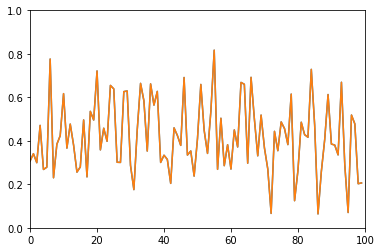

In [159]:
# distribution of dice coefficient 
image_index = []
for i in range(len(train_images)):
    image_index.append(i)
    

plt.plot(image_index,dice_coefficient_images)

plt.plot(image_index,dice_coefficient_images)
plt.axis([0, len(image_index), 0, 1])
plt.show()

In [160]:
all_class_predictions = np.array(all_class_predictions)
all_ground_truth_classes = np.array(all_ground_truth_classes)


# print(all_class_predictions)
# print(all_ground_truth_classes)


# determine accuracy,recall,precision
accuracy = accuracy_score(all_class_predictions, all_ground_truth_classes)
print("LOCALIZATION + CLASSIFICATION ACCURACY : ", accuracy)
precision = precision_score(all_class_predictions, all_ground_truth_classes, average = 'micro')
print("LOCALIZATION + CLASSIFICATION PRECISION : ", precision)
recall = recall_score(all_class_predictions, all_ground_truth_classes, average='micro')
print("LOCALIZATION + CLASSIFICATION RECALL : ", recall)


LOCALIZATION + CLASSIFICATION ACCURACY :  0.037383177570093455
LOCALIZATION + CLASSIFICATION PRECISION :  0.037383177570093455
LOCALIZATION + CLASSIFICATION RECALL :  0.037383177570093455
